<a href="https://colab.research.google.com/github/dung18520632/NhanDien_CS338.L21/blob/main/Optimize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%cd /content/drive/MyDrive/darknet

/content/drive/MyDrive/darknet


In [3]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile


In [ ]:
!make

In [84]:
def load_network_1(config_file, data_file, weights, batch_size=1):
    """
    load model description and weights from config files
    args:
        config_file (str): path to .cfg model file
        data_file (str): path to .data model file
        weights (str): path to weights
    returns:
        network: trained model
        class_names
        class_colors
    """
    network = load_net_custom(
        config_file.encode("ascii"),
        weights.encode("ascii"), 0, batch_size)
    metadata = load_meta(data_file.encode("ascii"))
    class_names = [metadata.names[i].decode("ascii") for i in range(1)]
    colors = class_colors(class_names)
    return network, class_names, colors

In [85]:
from darknet import *
#608X608
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network_1("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
width = network_width(network)
height = network_height(network)

In [86]:
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

In [87]:
def Detection(detections,image):
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  cv2_imshow(image)

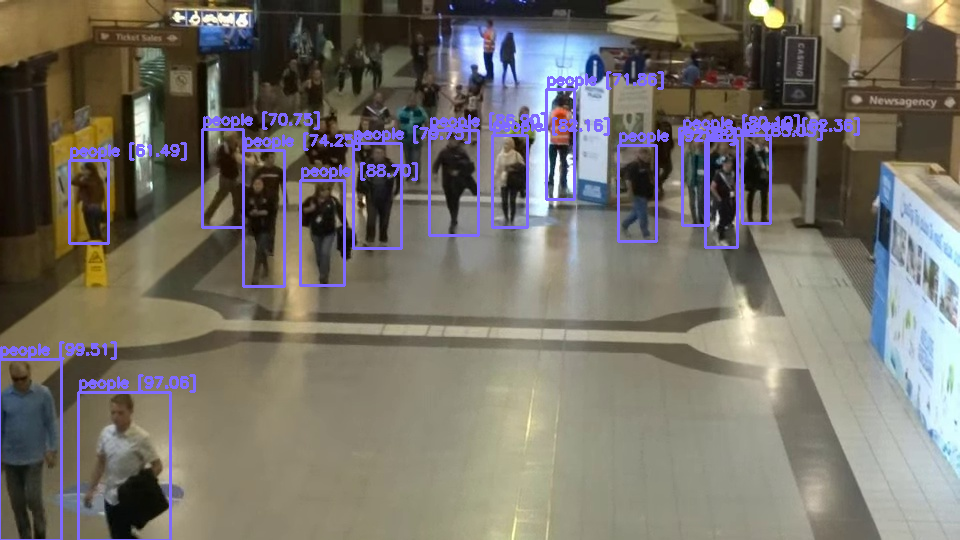

In [88]:
image = cv2.imread("/content/MOT20_02_raw_frame_100.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)
boxes = [bbox for _,_,bbox in detections]
Detection(detections,image)

In [89]:
original_image_BGR = cv2.imread('/content/MOT20_02_raw_frame_100.jpg')
original_image_RGB = cv2.cvtColor(original_image_BGR, cv2.COLOR_BGR2RGB)
image_width = original_image_RGB.shape[1]
image_height = original_image_RGB.shape[0]

original_image_BGR_copy = original_image_BGR.copy()
original_image_RGB_copy = original_image_RGB.copy()

print('image Shape', original_image_RGB.shape)

image Shape (540, 960, 3)


[[142. 298.]
 [784. 315.]
 [811. 371.]
 [ 82. 347.]]


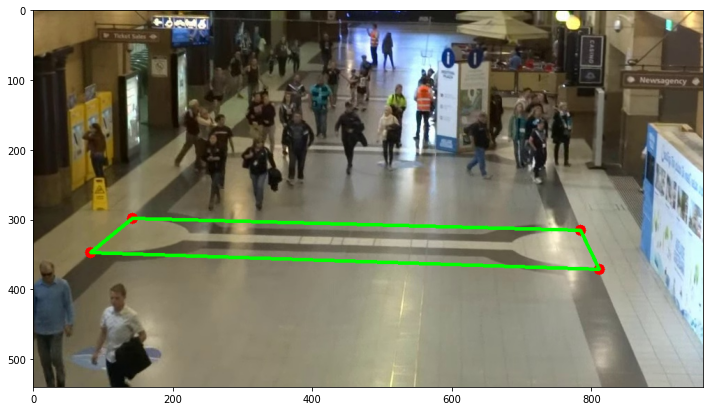

The perspective transform matrix:
[[ 4.64100594e+00  8.20914118e+00 -2.16714663e+03]
 [ 8.94136789e-02  2.14071423e+01 -1.19908691e+03]
 [ 3.12807115e-04  1.61722589e-02  1.00000000e+00]]


In [124]:
src = np.float32([[142., 298.],
                           [784., 315.],
                           [811., 371.],
                           [ 82., 347.]])
for point in src:
    cv2.circle(original_image_RGB_copy, tuple(point), 8, (255, 0, 0), -1)

points = src.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(original_image_RGB_copy, [points], True, (0,255,0), thickness=4)
plt.figure(figsize=(12, 12))
plt.imshow(original_image_RGB_copy)
plt.show()
dst=np.float32([(0.2,0.82), (0.80, 0.82), (0.80,0.87), (0.2,0.87)])

dst_size=(800,1080)
dst = dst * np.float32(dst_size)

H_matrix = cv2.getPerspectiveTransform(src, dst)
print("The perspective transform matrix:")
print(H_matrix)

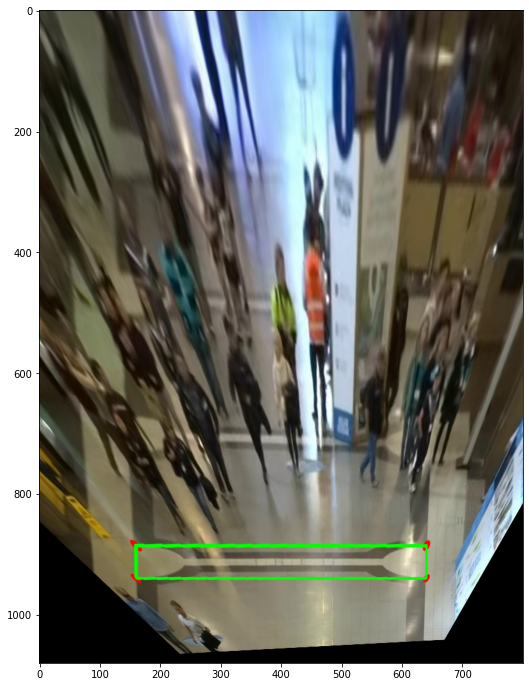

In [91]:
warped = cv2.warpPerspective(original_image_RGB_copy, H_matrix, dst_size)

plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.show()

In [92]:
print(boxes)

[(56.766902923583984, 227.53843688964844, 24.610671997070312, 93.65724182128906), (478.92181396484375, 202.41207885742188, 18.17322540283203, 98.20350646972656), (140.80422973632812, 201.23509216308594, 25.638771057128906, 109.70458221435547), (354.69378662109375, 163.1175079345703, 17.68016242980957, 123.41414642333984), (167.23782348632812, 246.6632080078125, 25.59459686279297, 152.3776397705078), (239.0293731689453, 221.17103576660156, 29.301136016845703, 117.56430053710938), (440.8598937988281, 201.6088409423828, 17.216053009033203, 105.60368347167969), (322.8179016113281, 203.99851989746094, 21.822799682617188, 103.52877807617188), (456.971435546875, 218.32192993164062, 19.249671936035156, 120.44384765625), (287.2624206542969, 205.8551483154297, 30.637638092041016, 117.52120208740234), (203.9088592529297, 262.7707214355469, 28.558443069458008, 118.55130767822266), (404.3387756347656, 218.37167358398438, 23.875457763671875, 108.15023803710938), (79.37675476074219, 525.3857421875, 5

In [123]:
def Point_transform(detections,H_matrix,boxes):
      list_downoids = [[bbox[0],bbox[1]+bbox[3]//2] for bbox in boxes]
      list_points_to_detect=np.float32(list_downoids).reshape(-1,1,2)
      transformed_point=cv2.perspectiveTransform(list_points_to_detect,H_matrix)
      transformed_point_list= list()
      for i in range (0,transformed_point.shape[0]):
        transformed_point_list.append([transformed_point[i][0][0],transformed_point[i][0][1]])
      return np.array(transformed_point_list).astype('int')
birds_eye_points=Point_transform(detections,H_matrix,boxes)


[[56.766902923583984, 273.53843688964844], [478.92181396484375, 251.41207885742188], [140.80422973632812, 255.23509216308594], [354.69378662109375, 224.1175079345703], [167.23782348632812, 322.6632080078125], [239.0293731689453, 279.17103576660156], [440.8598937988281, 253.6088409423828], [322.8179016113281, 254.99851989746094], [456.971435546875, 278.3219299316406], [287.2624206542969, 263.8551483154297], [203.9088592529297, 321.7707214355469], [404.3387756347656, 272.3716735839844], [79.37675476074219, 607.3857421875], [18.972166061401367, 608.9781494140625]]


In [125]:
birds_eye_points

array([[  62,  856],
       [ 406,  810],
       [ 112,  827],
       [ 278,  766],
       [ 200,  912],
       [ 220,  858],
       [ 374,  814],
       [ 272,  820],
       [ 396,  850],
       [ 248,  835],
       [ 226,  910],
       [ 351,  843],
       [ 293, 1088],
       [ 269, 1090]])

In [94]:
from math import sqrt
def eucledian_distance(point1, point2):
    x1,y1 = point1
    x2,y2 = point2
    return sqrt((x1-x2)**2 + (y1-y2)**2)

In [128]:
def get_red_green_boxes(distance_allowed,Point_transform,boxes):
    red_boxes = []
    green_boxes = []
    new_boxes = [tuple(box) + tuple(result) for box, result in zip(boxes, birds_eye_points)]
    for i in range(0, len(new_boxes)-1):
            for j in range(i+1, len(new_boxes)):
                cxi,cyi = new_boxes[i][4:]
                cxj,cyj = new_boxes[j][4:]
                distance = eucledian_distance([cxi,cyi], [cxj,cyj])
                if distance < distance_allowed:
                    red_boxes.append(new_boxes[i])
                    red_boxes.append(new_boxes[j])
    print(len(red_boxes))
    green_boxes = list(set(new_boxes) - set(red_boxes))
    red_boxes = list(set(red_boxes))

    return (green_boxes, red_boxes)

In [130]:
min_distance = 60
green_box,red_box=get_red_green_boxes(min_distance, birds_eye_points, boxes)

26


In [119]:

def convertBack(x, y, w, h): 
    #================================================================
    # 2.Purpose : Converts center coordinates to rectangle coordinates
    #================================================================  
    """
    :param:
    x, y = midpoint of bbox
    w, h = width, height of the bbox
    
    :return:
    xmin, ymin, xmax, ymax
    """
    xmin = int(round(x - (w / 2)))
    xmax = int(round(x + (w / 2)))
    ymin = int(round(y - (h / 2)))
    ymax = int(round(y + (h / 2)))
    return xmin, ymin, xmax, ymax

In [120]:
def get_red_green_box_image(new_box_image,green_box,red_box):
    for point in green_box:
        xmin, ymin, xmax, ymax = convertBack(point[0], point[1], point[2],point[3])
        xmin, ymin, xmax, ymax = int(xmin * width_ratio), int(ymin * height_ratio), int(xmax * width_ratio), int(ymax * height_ratio)
        cv2.rectangle(new_box_image,(xmin,ymin),(xmax,ymax),(0, 255, 0), 2)
    for point in red_box:
        xmin, ymin, xmax, ymax = convertBack(point[0], point[1], point[2],point[3])
        xmin, ymin, xmax, ymax = int(xmin * width_ratio), int(ymin * height_ratio), int(xmax * width_ratio), int(ymax * height_ratio)
        cv2.rectangle(new_box_image,(xmin,ymin),(xmax,ymax),(0, 0, 255), 2)
    return new_box_image

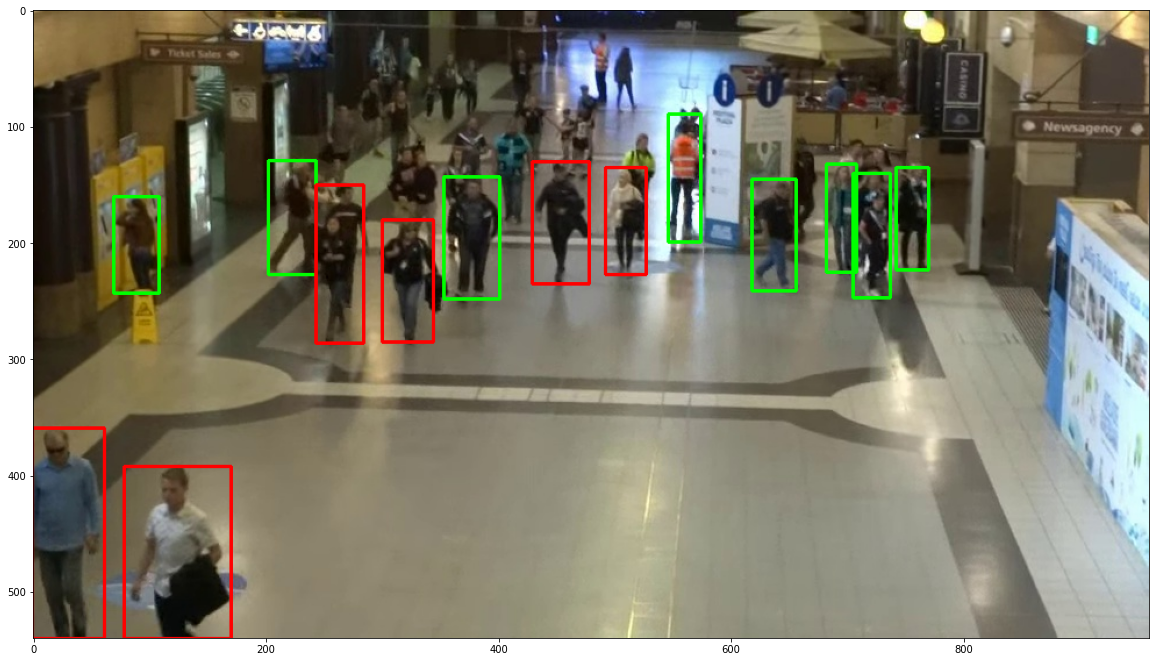

In [121]:
box_red_green_image = get_red_green_box_image(original_image_BGR.copy(),green_box,red_box)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(box_red_green_image, cv2.COLOR_RGB2BGR))
plt.show()

In [48]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [51]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>